<a href="https://colab.research.google.com/github/vin-nag/6915_a4/blob/master/presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<h1>Designing a deep neural network architecture to classify digits</h1>
    <h2>Project for COMP 6915</h2>
    <h2>by Ozah Nnamdi Wilson and Vineel Nagisetty</h2>  
</center>

This notebook overviews the design of a deep neural network architecture, using it to classify images using Stanford's "Street View House Numbers (SVHN) Dataset". Most of our code is inspired from the tutorial at: https://www.tensorflow.org/tutorials/keras/basic_classification

In [0]:
#Imports

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import sys

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils.generic_utils import get_custom_objects
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Step 1: Load data

We load the data available at: http://ufldl.stanford.edu/housenumbers/  The class names, described in the repository is created next.

In [81]:
# load data
train = io.loadmat('train_32x32.mat')
test = io.loadmat('test_32x32.mat')

# split to images and labels
train_images, train_labels = train['X'], train['y']
test_images, test_labels = test['X'], test['y']

#10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10.
class_names = [str(x) for x in range(1,10)] + ['0']

print('Shapes of data:')
print('train images: ', train_images.shape, ', test images: ', test_images.shape)
print('train images: ', train_labels.shape, ', test images: ', test_labels.shape)

Shapes of data:
train images:  (32, 32, 3, 73257) , test images:  (32, 32, 3, 26032)
train images:  (73257, 1) , test images:  (26032, 1)


Looking at the data, we have 73,257 training instances and 26,032 test instances which have 3 color channels in a 32 by 32 pixel image. This is what a sample image looks like

## Step 2: Pre-process data

Before we feed the data to the network, we need to re-order the data and convert the labels from [1,10] range to [0,9]. We also normalize the range of values from [0,255] to [0,1]

In [0]:
# re-order the data
train_images = np.transpose(train_images, (3,0,1,2))
test_images = np.transpose(test_images, (3,0,1,2))

# convert the labels
train_labels -= 1
test_labels -= 1

# normalize data
train_images = train_images / 255.0
test_images = test_images / 255.0

This is what sample images looks like in the dataset, with the labels given below

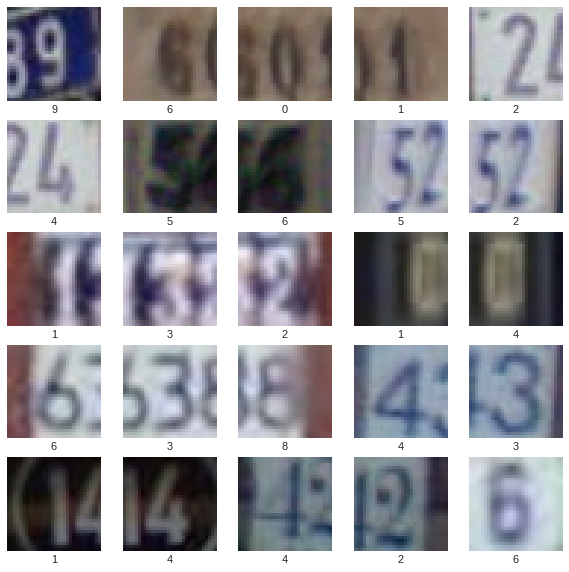

In [87]:
plt.figure(figsize=(10,10))
x=0
y=x+50
for i in range(y,y+25):
    plt.subplot(5,5,x+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i,:,:], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
    x+=1
plt.show()

## Step 3: Design the deep learning model

Deep neural networks, specifically convolutional neural networks, are optimized for image classification. This necessitates, without saying, that our model includes convolutions. In the next section, we give a description of our model architecture together with the justification of the selection of each in our model.

In [91]:
# create the model
model = Sequential()
  
# add input layer
model.add(Conv2D(32, (3, 3), activation=tf.nn.relu, input_shape=(32,32,3)))

# add hidden layers
model.add(Conv2D(32, (3, 3), activation=tf.nn.relu))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation=tf.nn.relu))
model.add(Conv2D(64, (3, 3), activation=tf.nn.relu))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# add dense layer
model.add(Flatten())
model.add(Dense(256, activation=tf.nn.relu))
model.add(Dropout(0.5))

# add output layer
model.add(Dense(10, activation=tf.nn.softmax))

# add other metrics
model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True), metrics=['accuracy'])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 5, 5, 64)          0         
__________

**Architecture:** Setting up the number of layers and their sizes was significant because there is always the temptation to have a large capacity with complicated functions, requiring a large number of layers. However, considering the no free lunch theory, the increased possibility of overfitting the training data makes us to select only 4 layers, and then select regularization techniques, such as dropout, to prevent overfitting. 

**Activation function:** Deep neural networks, according to krizhevsky et. al 2012, enjoy relatively fast training when the rectified linear activation function (relu) is used as the activation function.

**Loss function:** The dataset had more than 2 classes, so a binary function would not suffice. Although we experimented with different functions, to see which performs the best, we were constrained to the sparse categorical crossentropy rather than the categorical crossentropy because our targets are integers rather than one-hot encodings. In addition, sparse categorical crossentropy enables time and memory conservation, as the classes in our dataset are mutually exclusive.

**Optimizer:** For our optimizer, we chose the Stochastic Gradient Descent (SGD), which is an age long, simple and quite efficient method for discriminative learning of linear classifiers under convex loss functions. The choice of SGD as our optimizer is also hinged on the fact that our model is not too deep, thus we need an optimizer that will be smart enough to make small leaps and avoid overshooting the minima, enhanced by Nesterov accelerated gradient, and a low learning rate, specifically 0.01.

**Regularization:** One of the major challenges associated with a deep neural network, regardless of its power, is overfitting. Although our model is not a very deep neural network, we follow the simple and efficient method suggested by Hinton et. al, including Dropout as a technique to combat overfitting, and we find it quite effective in our model.

**Output function:**

## Step 4: Train the model

Here we are using 10 epochs.

In [92]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
73257/73257 [==============================] - 28s 387us/step - loss: 2.2391 - acc: 0.1884
Epoch 2/10
73257/73257 [==============================] - 28s 377us/step - loss: 2.0126 - acc: 0.2828
Epoch 3/10
73257/73257 [==============================] - 28s 379us/step - loss: 0.6630 - acc: 0.7953
Epoch 4/10
73257/73257 [==============================] - 28s 387us/step - loss: 0.5043 - acc: 0.8457
Epoch 5/10
73257/73257 [==============================] - 28s 386us/step - loss: 0.4515 - acc: 0.8637
Epoch 6/10
73257/73257 [==============================] - 28s 386us/step - loss: 0.4166 - acc: 0.8748
Epoch 7/10
73257/73257 [==============================] - 29s 389us/step - loss: 0.3922 - acc: 0.8817
Epoch 8/10
73257/73257 [==============================] - 29s 393us/step - loss: 0.3739 - acc: 0.8887
Epoch 9/10
73257/73257 [==============================] - 29s 401us/step - loss: 0.3603 - acc: 0.8919
Epoch 10/10
73257/73257 [==============================] - 29s 400us/step - loss: 

## Step 5: Evaluate the model

Let's look at an unbiased accuracy of the model using the test dataset

In [93]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

26032/26032 [==============================] - 5s 175us/step
Test accuracy: 0.9144898586355255


A test accuracy score of over 91% is a remarkable result, specially for a relatively smaller architecture. Let us now look at some of the more insightful evaluation metrics. We first need to get the predictions on the test images.

In [0]:
# get predictions
predictions = model.predict(test_images)

# convert nd prediction array to 1d predictions
results = np.argmax(predictions, axis=1)

### Confusion matrix

Also known as an error matrix, this is a specific table layout that allows visualization of the performance of an algorithm, typically a classification one.

Normalized confusion matrix


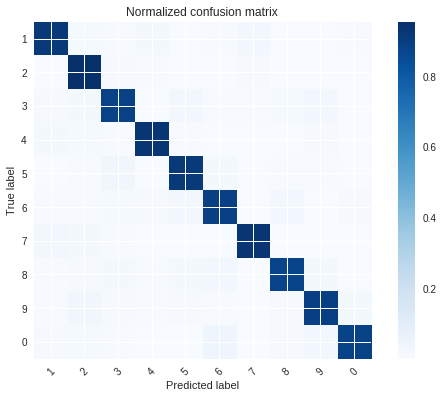

In [97]:
# function for graphing the entire matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cm = confusion_matrix(test_labels, results)
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

Looking at the matrix with high scores along the main diagonal, it is clear that  the model has been trained decently well, confirming our accuracy score earlier. Interestingly, some of the other spots that see some misclassification include 3 being mistaken for 5, 8 and 9, and 1 being mistaken for a 7. These digits are closer to each other and it makes sense the algorithm was tricked by them, versus some digits that are not similar at all such as 1 mistaken for an 8.

### Classification report

This report gives a better picture of the results, with precision, recall, f1-score values that show more than just the accuracy. 

In [98]:
print(classification_report(test_labels, results, target_names=class_names))

              precision    recall  f1-score   support

           1       0.96      0.92      0.94      5099
           2       0.93      0.95      0.94      4149
           3       0.90      0.89      0.89      2882
           4       0.92      0.93      0.93      2523
           5       0.91      0.92      0.91      2384
           6       0.88      0.89      0.88      1977
           7       0.90      0.93      0.91      2019
           8       0.89      0.88      0.88      1660
           9       0.86      0.90      0.88      1595
           0       0.94      0.88      0.91      1744

   micro avg       0.91      0.91      0.91     26032
   macro avg       0.91      0.91      0.91     26032
weighted avg       0.92      0.91      0.91     26032



Interestingly, all the labels generated precision and recall of over 85%, making our model reliable to use. 

Finally, let us select few random images from test data and see our model's prediction for it along with the confidence score

In [0]:
# code used from the tutorial
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label[0]]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label[0]].set_color('blue')

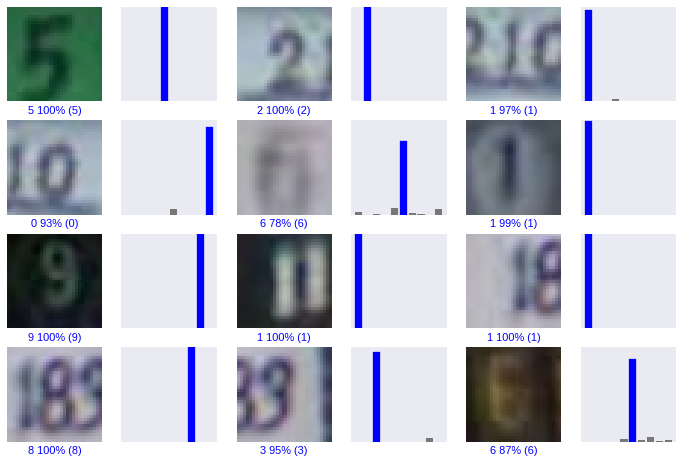

In [60]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 4
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)
plt.show()

As can be seen from these images, our model is highly confident of its prediction for the clearer digits, and it is correct in those cases. For the 6, 1 in row 2 and 6 in last row, our model was not as confident (although it predicted correctly). Interestingly, the 2nd highest confidence score for the 6 in the bottom row was for label 8, and it makes sense since 8 is the digit that looks closest to 6.

However, these digits aren't clear at all, and humans could very well have performed worse on this. From this we can infer that even though our model could be improved to a slightly higher accuracry (perhaps 95 to 96%?), it would not get to 100% since the data has digits of poor quality. If our random sampling already showed 3 poor quality digits, imagine their total number in the dataset of around 100,000 instances.a